# Preliminary analysis

## Are artific people also scientistic ? (find a catch phrase like "Make it pope-litical")

We are often put into boxes regarding our interests and hobbies, we have friends that have the same interests as us, we chose a department when we are young at high school and social media makes a lot of suggestions based on our past interests. We sometimes hear that artistic and scientific people are different, closed-minded in their subject and not interested in the other one. The main goal of this project is to study this stereotype by using the YouNiverse dataset using comments and video metadata files. We want to determine whether comment authors that have at least a particular amount of comments solely comment on one or both of the following categories: artistic/scientific, or both. We can examine whether it's true or not that the majority of profiles that comment on art videos never comment on scientific videos. To draw some conclusions about people’s interests, we can determine if the profiles that consider both types of videos mix them together over one time period or if they are more evenly distributed over several.

## Useful libraries

In [24]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
mpl.rcParams['figure.facecolor'] = 'white'
import os
import sys
import re
from wordcloud import WordCloud

## Data preprocessing

### Data sampling

Two files after processing:

- A sample of users and their comments.
- A list of videos on which our pool of user have commented.

Remove title, description, crawl_date.


In [ ]:
# n_authors between 500 000 and 1 million

# get one chunk of comments to recover n_authors

# save authors file

# Get unique video id

# Load chunk by chunk video metadata
    # keep only intersection of videos
    # Drop title, description, crawldate

# Save videoset, dont forget to reset_index() and drop the previous index column


Maybe verify that sample datasets corresponds to the total population with plots video categories

Plots

### Data importation

In [ ]:
# datapath = 'C:\Users\Kelyan\OneDrive\Documents\GitHub\ada-2022-project-geksada'
# yt_meta_path = os.path.join(datapath, "yt_metadata_en.jsonl.gz")
# yt_meta_16_feater = os.path.join(datapath, "video_metadata2016.feather")

In [4]:
# yt_meta_16_feater = os.path.join(datapath, "video_metadata2016.feather")
df_meta_16 = pd.read_feather("video_metadata2016.feather")

In [5]:
print(len(df_meta_16))
df_meta_16.head()

4130410


,index,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,185,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,3.0,jCaqrZ8gSkY,116,11.0,"learn colors,kids colors,colors kids,count to ...",2016-05-03 00:00:00,2720.0
1,2658,Music,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:42:09.015401,28.0,WVapFh7cx3M,142,184.0,"En Av oss,one of us,project,Gutterommet,music,...",2016-06-06 00:00:00,4360.0
2,3862,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.215349,0.0,Qr8sptZ2vyA,266,25.0,"Atis Freivalds,Paradox,scary music,dark ambien...",2016-12-27 00:00:00,697.0
3,3863,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.849022,8.0,ZA5EW-DKS6M,473,188.0,"Psionic Asylum,Mental Jail,scary music,horror ...",2016-12-26 00:00:00,10387.0
4,3864,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:42.494555,2.0,bXlmyO-iW8g,192,35.0,"Clau||M,Dioxin,creepy msuic,epic horror music,...",2016-11-06 00:00:00,1702.0


### Data filtering

Explain: artistic video category do not exist => so we made ours
=> explain how with dictionnaries

In [6]:
# Formatting the tags column in order to do exact word matching

##  USE str.strip !!!


df_meta_16=df_meta_16[:15000] # for easiness of processing
df_meta_16['tags'] = df_meta_16['tags'].apply(str.lower)
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=(';',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=(',',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=('(',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=(')',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=('&',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=('|',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.split)

In [7]:
df_meta_16.head()

,index,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,185,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,3.0,jCaqrZ8gSkY,116,11.0,"[learn, colors, kids, colors, colors, kids, co...",2016-05-03 00:00:00,2720.0
1,2658,Music,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:42:09.015401,28.0,WVapFh7cx3M,142,184.0,"[en, av, oss, one, of, us, project, gutteromme...",2016-06-06 00:00:00,4360.0
2,3862,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.215349,0.0,Qr8sptZ2vyA,266,25.0,"[atis, freivalds, paradox, scary, music, dark,...",2016-12-27 00:00:00,697.0
3,3863,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.849022,8.0,ZA5EW-DKS6M,473,188.0,"[psionic, asylum, mental, jail, scary, music, ...",2016-12-26 00:00:00,10387.0
4,3864,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:42.494555,2.0,bXlmyO-iW8g,192,35.0,"[clau, m, dioxin, creepy, msuic, epic, horror,...",2016-11-06 00:00:00,1702.0


Some helper functions

In [8]:
def return_word_in_list(tags, word_list):
    
    # Make sets from the list of words
    x = set(tags)
    y = set(word_list)
    
    # Use intersection function of set type to quickly find which word are in both lists/sets
    z = x.intersection(y)

    return z

In [9]:
def check_tags_in_list(tags, word_list):
    word_present = 0
    
    # Make sets from the list of words
    x = set(tags)
    y = set(word_list)
    
    # Use intersection function of set type to quickly find which word are in both lists/sets
    z = x.intersection(y)
    
    # If the intersection is larger than 0, then there is at least a common word between both sets 
    if len(z) > 0:
        word_present = 1
    return word_present

#### Artistic videos

In [10]:
# Art words
words_path_visual = "dictionaries/visual_arts.txt"
words_path_performing = "dictionaries/performing_art.txt"
words_path_literary = "dictionaries/literary_art.txt"

visual_arts = pd.read_csv(words_path_visual)
literary_arts = pd.read_csv(words_path_literary)
performing_arts = pd.read_csv(words_path_performing)

visual_words = visual_arts.values
literary_words = literary_arts.values
performing_words = performing_arts.values

visual_words = visual_words.flatten()
literary_words = literary_words.flatten()
performing_words = performing_words.flatten()


# maybe only print samples of each
 
print(visual_words)
print(literary_words)
print(performing_words)

['ceramics' 'draw' 'draw in' 'drawing' 'drawings' 'paint' 'painter'
 'painting' 'paintings' 'sculpt' 'sculptor' 'sculpture' 'sculptures'
 'statue' 'statues' 'statuary' 'fresco' 'printmaking' 'linoleum'
 'linocut ' 'design' 'designs' 'designer' 'designers' 'craft' 'crafts'
 'photography' 'film-making' 'architect' 'architecture' 'architectures'
 'maquette' 'maquettes' 'pottery' 'potteries' 'earthenware' 'earthenwares'
 'terracotta' 'vase' 'vases' 'clayware' 'mosaic' 'mosaics' 'carve'
 'carving' 'motifs' 'sketching' 'sketchings' 'sketched' 'doodle' 'doodles'
 'doodling' 'dooodlings' 'acrylic' 'acrylic paint' 'oil paint'
 'spray paint' 'artwork' 'artworks' 'photojournalism' 'aperture'
 'exposure']
['literatures' 'writing' 'text' 'texts' 'poetry' 'prose' 'assonance'
 'alliteration' 'rhythm' 'poem' 'poems' 'novel' 'novels' 'romance'
 'novella' 'theatre' 'article' 'articles' 'biography' 'biographies'
 'essay' 'essays' 'pamphlet' 'abstract' 'book' 'books' 'letter' 'letters'
 'writings' 'litera

In [11]:
df_meta_16['visual_art'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, visual_words))
df_meta_16['literary_art'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, literary_words))
df_meta_16['performing_art'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, performing_words))
df_meta_16["art"] = 0
df_meta_16["art"].loc[(df_meta_16.visual_art == 1) | (df_meta_16.literary_art == 1) | (df_meta_16.performing_art == 1)] = 1

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_432\1339503544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_16["art"].loc[(df_meta_16.visual_art == 1) | (df_meta_16.literary_art == 1) | (df_meta_16.performing_art == 1)] = 1


In [12]:
df_meta_16['visual_art_word'] = df_meta_16['tags'].apply(lambda x : return_word_in_list(x, visual_words))
df_meta_16['literary_art_word'] = df_meta_16['tags'].apply(lambda x : return_word_in_list(x, literary_words))
df_meta_16['performing_art_word'] = df_meta_16['tags'].apply(lambda x : return_word_in_list(x, performing_words))

In [13]:
df_science = df_meta_16.loc[df_meta_16.art == 1]

#### Scientific videos

Explain how we categorize and filter scientific videos between theoretical and practical science.

Not based on categories but only on dictionary filtering.

Define dictionaries for theoretical and practical science videos.

In [16]:
# Science words
words_path_natural = "dictionaries/natural_science.txt"
words_path_technical = "dictionaries/technical_science.txt"

natural_science = pd.read_csv(words_path_natural)
technical_science = pd.read_csv(words_path_technical)

natural_words = natural_science.values
technical_words = technical_science.values

natural_words = natural_words.flatten()
technical_words = technical_words.flatten()

# maybe only print samples of each
 
print(natural_words)
print(technical_words)

['quantum' 'physics' 'mathematics' 'atom' 'relativity' 'gravity'
 'scientific' 'scientifics' 'theorem' 'theorems' 'spactime' 'einstein'
 'entropy' 'entropies' 'molecule' 'molecules' 'atomism' 'magnetism'
 'galaxy' 'electron' 'metaphysics' 'universe' 'metaphysical'
 'theoretician' 'theoreticians' 'physicist' 'physicists' 'astronomy'
 'axiom' 'axioms' 'archimede' 'archimedes' 'pythagoras' 'mole'
 'oscillation' 'lorentz' 'maxwell' 'photoelectric' 'newton' 'maths'
 'radioactivity' 'arithmetic' 'geometry' 'mathematical' 'chemistry'
 'particle' 'particles' 'riemann' 'chemistries' 'biology' 'cellule' 'cell'
 'cells' 'biophysics' 'thermodynamics' 'optics' 'landau' 'meteorology'
 'geology' 'astrochemistry' 'kepler' 'spectroscope' 'geophysics']
['technologies' 'technological' 'engineering' 'engineer' 'engineers'
 'tech' 'systems' 'system' 'nanotechnology' 'robotics' 'electronics'
 'biotechnology' 'device' 'devices' 'automation' 'code' 'innovation'
 'innovations' 'wireless' 'hardware' 'robot' 'ro

In [32]:
df_meta_16['natural_science'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, natural_words))
df_meta_16['technical_science'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, technical_words))
df_meta_16["science"] = 0
df_meta_16["science"].loc[(df_meta_16.natural_science == 1) | (df_meta_16.technical_science == 1)] = 1

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_432\260793676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_16["science"].loc[(df_meta_16.natural_science == 1) | (df_meta_16.technical_science == 1)] = 1


In [33]:
df_meta_16['natural_science_word'] = df_meta_16['tags'].apply(lambda x : return_word_in_list(x, natural_words))
df_meta_16['technical_science_word'] = df_meta_16['tags'].apply(lambda x : return_word_in_list(x, technical_words))

In [34]:
df_science = df_meta_16.loc[df_meta_16.science == 1]

#### User profiles

Add columns for commented_artistic and commented_scientific (boolean values)

## Exploratory Data Analysis

### Videos

To have a global overview:

Plot of video distribution by categories (from youtube)

Then plot artistic video % vs scientific video % (pie chart).

Then add venn diagram of the intersections between artistic and scientific video

Then add time plot of percentage of views on artistic vs scientific videos

Add same plot for category distribution of scientific videos
row 1: big subplot for all the categories
row 2: smaller plots for artstic categories and scientific categories

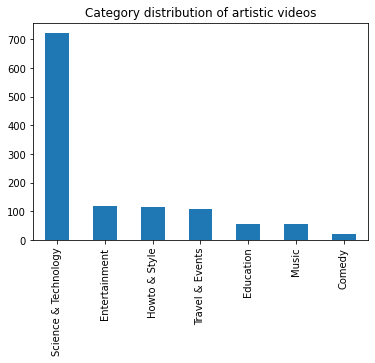

In [35]:
plt.figure()
df_science.categories.value_counts().plot(kind='bar')
plt.title("Category distribution of artistic videos")
plt.show()

### Artistic videos

#### Artistic domains distribution and time dependancy

Add time plot on the left of the pie chart

In [36]:
perc = (df_science.shape[0]*100)/df_meta_16.shape[0]
print("The art category corresponds to", round(perc, 2), "% of the videos.")

The art category corresponds to 8.01 % of the videos.


Text(0, 0.5, '')

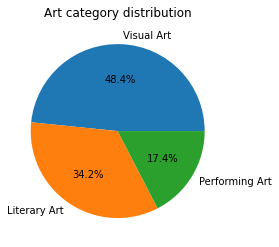

In [37]:
sum_arts = df_science[["visual_art", "literary_art", "performing_art"]].sum()
sum_arts.plot(kind="pie", labels = ["Visual Art", "Literary Art", "Performing Art"], autopct='%1.1f%%')
plt.title("Art category distribution")
plt.ylabel("")

So two rows:

row 1: percentage of videos per domain => pie + time
row 2: percentage of views per domain => pie + time


Check if there is a consistency of uploading artistic videos or if there are some patterns.

=> update with new dataset

=> instead of video count, plot the percentage of artistic video views vs percentage

In [38]:
# Convert upload date to only date format
df_meta_16['upload_date'] = pd.to_datetime(df_meta_16['upload_date'], format='%Y-%m-%d').dt.date
df_science['upload_date'] = pd.to_datetime(df_science['upload_date'], format='%Y-%m-%d').dt.date

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_432\455692652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_science['upload_date'] = pd.to_datetime(df_science['upload_date'], format='%Y-%m-%d').dt.date


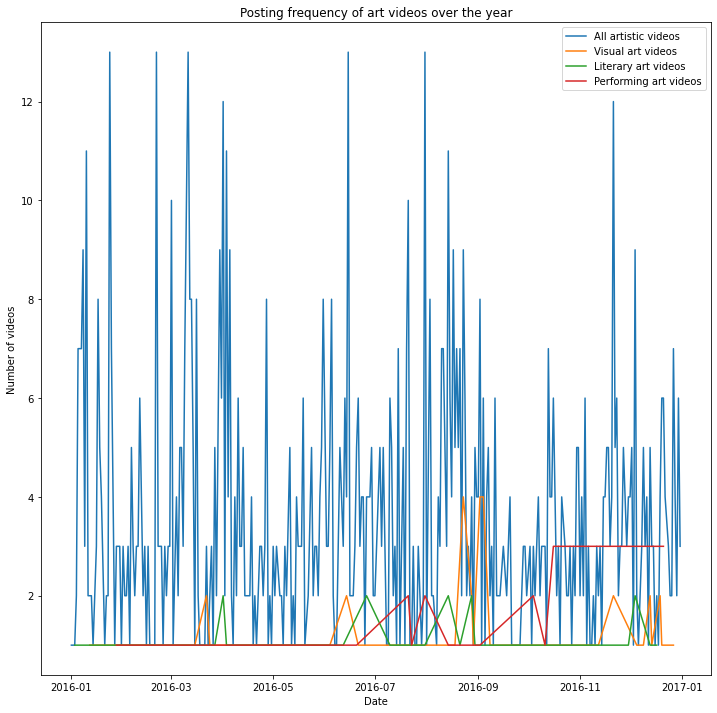

In [39]:
all_art_vid_count_year = df_science.groupby("upload_date").count().channel_id
vis_art_vid_count_year = df_science[df_science.visual_art==1].groupby("upload_date").count().channel_id
lit_art_vid_count_year = df_science[df_science.literary_art==1].groupby("upload_date").count().channel_id
perf_art_vid_count_year = df_science[df_science.performing_art==1].groupby("upload_date").count().channel_id

plt.figure(figsize=(12,12))
plt.plot(all_art_vid_count_year, label="All artistic videos")
plt.plot(vis_art_vid_count_year, label="Visual art videos")
plt.plot(lit_art_vid_count_year, label="Literary art videos")
plt.plot(perf_art_vid_count_year, label="Performing art videos")
plt.legend()
plt.title('Posting frequency of art videos over the year')
plt.xlabel('Date')
plt.ylabel('Number of videos')
plt.show()


#### Intersection of artistic domains

Using Venn diagram, we can see the distribution of types of art in defined artistic category, as well as see videos with two or all three tags

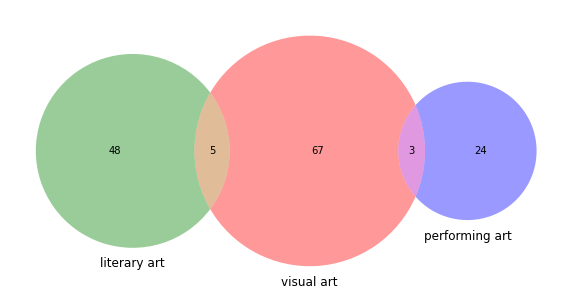

In [40]:
from matplotlib_venn import venn3

vis = df_science[(df_science['visual_art'] == 1)] 
lit = df_science[(df_science['literary_art'] == 1)]
perf = df_science[(df_science['performing_art'] == 1)]

plt.figure(figsize=(10,10))
set1 = set(vis['index'])
set2 = set(lit['index'])
set3 = set(perf['index'])

venn3([set1, set2, set3], ['visual art', 'literary art', 'performing art'])

plt.show()

#### Artistic tags usage

Add subplot with word cloud next to one another with appropriate titles.

Remove histograms.

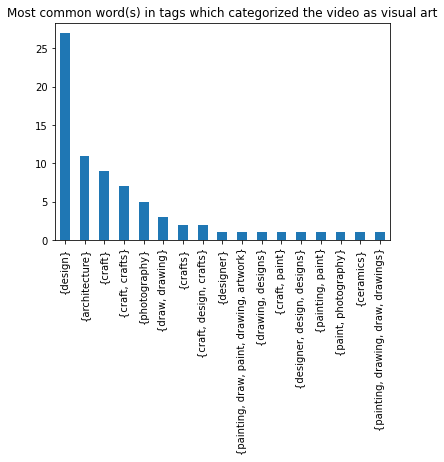

In [42]:
plt.figure()
df_science.loc[df_science.visual_art == 1].visual_art_word.value_counts().head(20).plot(kind='bar')
plt.title("Most common word(s) in tags which categorized the video as visual art")
plt.show()

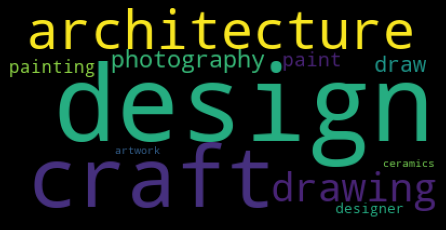

In [44]:
list_vis = []
list_sth=[list_vis.extend(x) for x in df_science.loc[df_science.visual_art == 1].visual_art_word]
visual_string=(" ").join(list_vis)

wordcloud = WordCloud(collocations=False).generate(visual_string)
plt.figure(facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

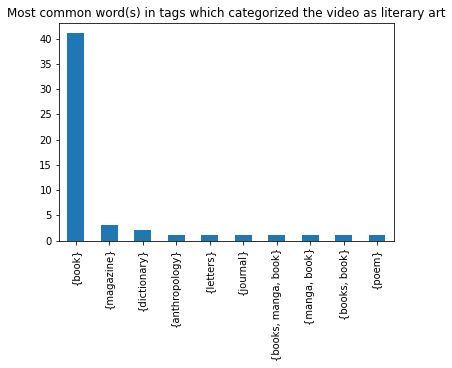

In [45]:
plt.figure()
df_science.loc[df_science.literary_art == 1].literary_art_word.value_counts().head(10).plot(kind='bar')
plt.title("Most common word(s) in tags which categorized the video as literary art")
plt.show()

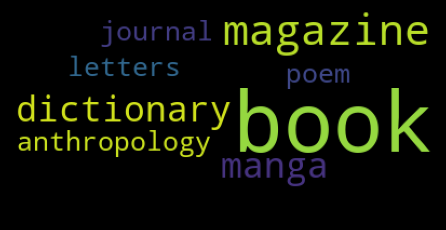

In [46]:
list_lit = []
list_sth=[list_lit.extend(x) for x in df_science.loc[df_science.literary_art == 1].literary_art_word]
literary_string=(" ").join(list_lit)

wordcloud = WordCloud(collocations=False).generate(literary_string)
plt.figure(facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

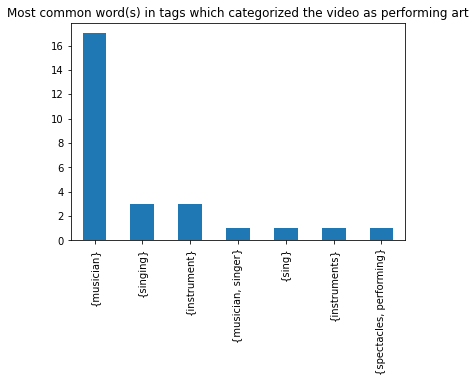

In [47]:
plt.figure()
df_science.loc[df_science.performing_art == 1].performing_art_word.value_counts().head(10).plot(kind='bar')
plt.title("Most common word(s) in tags which categorized the video as performing art")
plt.show()

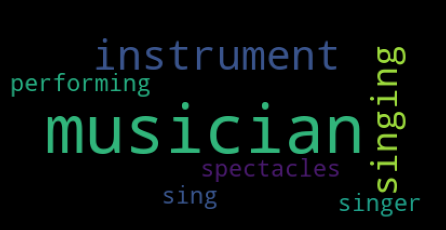

In [48]:
list_perm = []
list_sth=[list_perm.extend(x) for x in df_science.loc[df_science.performing_art == 1].performing_art_word]
performing_string=(" ").join(list_perm)

wordcloud = WordCloud(collocations=False).generate(performing_string)
plt.figure(facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Scientific videos

#### Scientific domains distribution and time dependancy

Add time plot on the left of the pie chart

In [49]:
perc = (df_science.shape[0]*100)/df_meta_16.shape[0]
print("The science category corresponds to", round(perc, 2), "% of the videos.")

The science category corresponds to 8.01 % of the videos.


Text(0, 0.5, '')

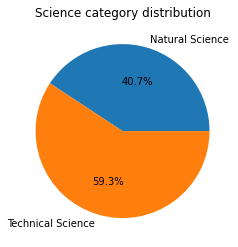

In [50]:
sum_science = df_science[["natural_science", "technical_science"]].sum()
sum_science.plot(kind="pie", labels = ["Natural Science", "Technical Science"], autopct='%1.1f%%')
plt.title("Science category distribution")
plt.ylabel("")

So two rows:

row 1: percentage of videos per domain => pie + time
row 2: percentage of views per domain => pie + time


Check if there is a consistency of uploading scientific videos or if there are some patterns.

=> update with new dataset

=> instead of video count, plot the percentage of scientific video views vs percentage

In [51]:
# Convert upload date to only date format
df_meta_16['upload_date'] = pd.to_datetime(df_meta_16['upload_date'], format='%Y-%m-%d').dt.date
df_science['upload_date'] = pd.to_datetime(df_science['upload_date'], format='%Y-%m-%d').dt.date

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_432\455692652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_science['upload_date'] = pd.to_datetime(df_science['upload_date'], format='%Y-%m-%d').dt.date


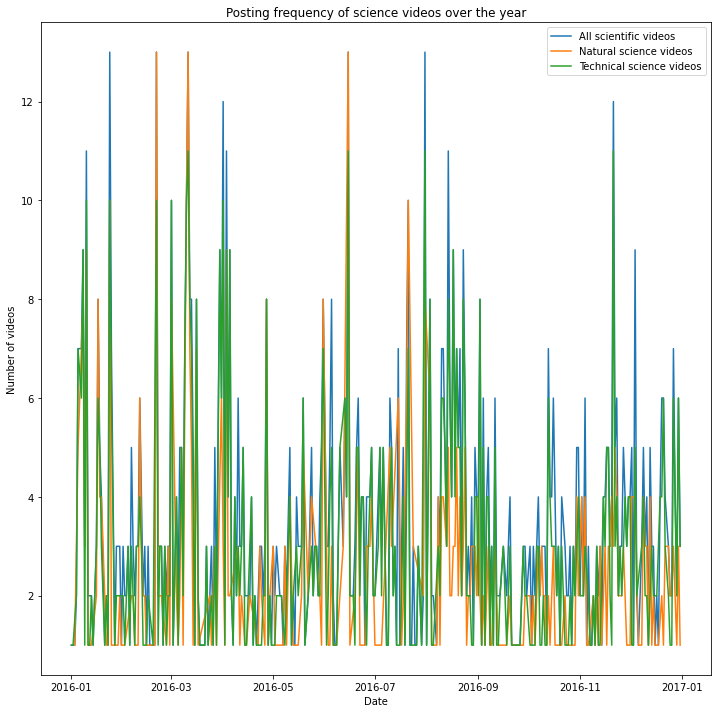

In [52]:
all_science_vid_count_year = df_science.groupby("upload_date").count().channel_id
nat_science_vid_count_year = df_science[df_science.natural_science==1].groupby("upload_date").count().channel_id
tec_science_vid_count_year = df_science[df_science.technical_science==1].groupby("upload_date").count().channel_id

plt.figure(figsize=(12,12))
plt.plot(all_science_vid_count_year, label="All scientific videos")
plt.plot(nat_science_vid_count_year, label="Natural science videos")
plt.plot(tec_science_vid_count_year, label="Technical science videos")
plt.legend()
plt.title('Posting frequency of science videos over the year')
plt.xlabel('Date')
plt.ylabel('Number of videos')
plt.show()


#### Intersection of scientific domains

Using Venn diagram, we can see the distribution of types of art in defined artistic category, as well as see videos with two or all three tags

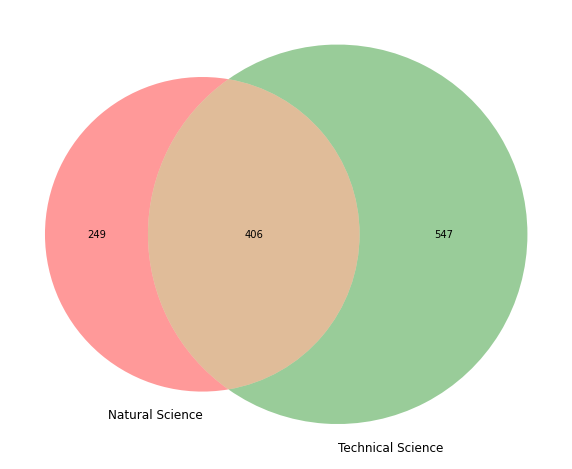

In [53]:
from matplotlib_venn import venn2

nat = df_science[(df_science['natural_science'] == 1)] 
tec = df_science[(df_science['technical_science'] == 1)]

plt.figure(figsize=(10,10))
set1 = set(nat['index'])
set2 = set(tec['index'])

venn2([set1, set2], ['Natural Science', 'Technical Science'])

plt.show()

#### Scientific tags usage

Add subplot with word cloud next to one another with appropriate titles.

Remove histograms.

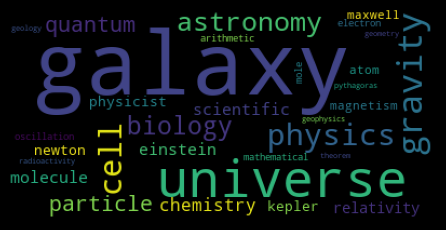

In [54]:
list_vis = []
list_sth=[list_vis.extend(x) for x in df_science.loc[df_science.natural_science == 1].natural_science_word]
visual_string=(" ").join(list_vis)

wordcloud = WordCloud(collocations=False).generate(visual_string)
plt.figure(facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

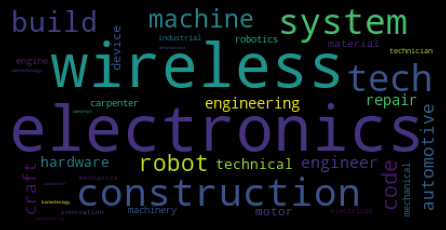

In [56]:
list_lit = []
list_sth=[list_lit.extend(x) for x in df_science.loc[df_science.technical_science == 1].technical_science_word]
literary_string=(" ").join(list_lit)

wordcloud = WordCloud(collocations=False).generate(literary_string)
plt.figure(facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Scientific domains distribution and time dependency

#### Intersection of science domains

#### Scientific tags usage

### Users & comments

#### Descriptive statistic 

mean/ variance/ median ...

Histogram Number of comments per category

### Others

In [ ]:
# plt.figure(figsize=(15,15))
# sns.heatmap()
# plt.title("Posting of artistic videos over a year ")
# plt.xlabel('Months')
# plt.ylabel('Number of posted videos')
# plt.show()

TypeError: heatmap() missing 1 required positional argument: 'data'

<Figure size 1080x1080 with 0 Axes>